### State Space Model

很多时间序列的模型都可以写成State Space Model的形式，这样就可以用一个统一的框架对时间序列进行分析，这样不同模型之间的相似性和差异性都可以明显的得到体现。

In [42]:
# 导入第三方包
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import statsmodels.api as sm

### Example 17.1

首先按照Muth Model的形式生成一个时间序列：
$$
y_t=\alpha_t+\epsilon_t\ \ \ \ E(\epsilon_t)=0\ \ \ \ V(\epsilon_t)=h\\
\alpha_t=\alpha_{t-1}+\eta_t\ \ \ \ E(\eta_t)=0\ \ \ \ V(\eta_t)=q=\kappa h\\
$$

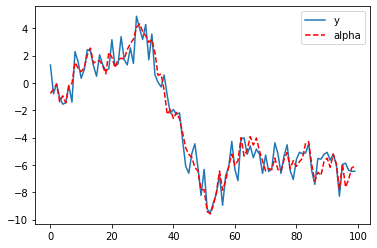

In [36]:
n=100
rho=2000
sigmae=0.6
sigmaeta=0.8
np.random.seed(7)
e=np.sqrt(sigmae)*np.random.randn(n)
eta=np.sqrt(sigmaeta)*np.random.randn(n)
y=np.zeros(n)
alpha=np.zeros(n)
y[0]=e[0]
alpha[0]=eta[0]
for t in range(1,n):
    alpha[t]=alpha[t-1]+eta[t]
    y[t]=alpha[t]+e[t]
plt.plot(y,label='y')
plt.plot(alpha,'r--',label='alpha')
plt.legend()
plt.show()

然后按照卡尔曼滤波的迭代公式计算a和p。此处因为缺少初始值，我们给p一个正数作为初值：

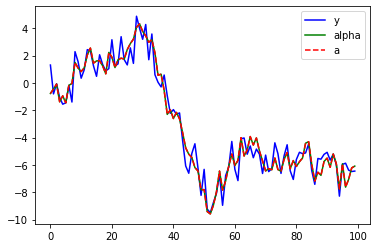

In [37]:
a=np.zeros(n)
p=np.zeros(n)
p[0]=1
k=np.zeros(n)
v=np.zeros(n)
for t in range(1,n):
  k[t]=(p[t-1])/(p[t-1]+sigmae)
  p[t]=p[t-1]-k[t]*p[t-1]+sigmaeta
  v[t]=y[t]-a[t-1]
  a[t]=a[t-1]+k[t]*v[t]
plt.plot(y,'b',label='y')
plt.plot(alpha,'g',label='alpha')
plt.plot(alpha,'r--',label='a')
plt.legend()
plt.show()

上面我们给p一个较小的初值，但是如果p的初值趋近于正无穷，那么无论a[0]从初值取多少，最终a[1]将会和y[1]相等

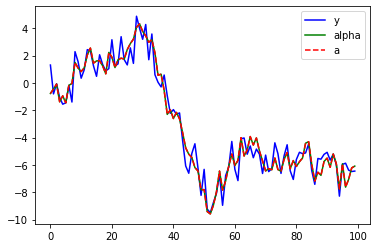

a[1]= -0.7992850740977631
y[1]= -0.7992898698082077


In [38]:
a=np.zeros(n)
p=np.zeros(n)
p[0]=100000
k=np.zeros(n)
v=np.zeros(n)
for t in range(1,n):
  k[t]=(p[t-1])/(p[t-1]+sigmae)
  p[t]=p[t-1]-k[t]*p[t-1]+sigmaeta
  v[t]=y[t]-a[t-1]
  a[t]=a[t-1]+k[t]*v[t]
plt.plot(y,'b',label='y')
plt.plot(alpha,'g',label='alpha')
plt.plot(alpha,'r--',label='a')
plt.legend()
plt.show()
print('a[1]=',a[1])
print('y[1]=',y[1])

对于h或$\kappa$的情况，卡尔曼滤波仍然有效，因为h=0就对应没有观测误差，模型就是一个纯随机游走；如果$\kappa=0$，那么y的均值就会稳定在$\alpha$。

### Example 17.2

下面我们对Muth Model进行预测：

In [39]:
a=np.zeros(n)
p=np.zeros(n)
p[0]=10000
k=np.zeros(n)
v=np.zeros(n)
def conML(mypa):
    q=abs(mypa)
    z=1
    w=1
    likelihood=0
    sigmae=0
    for t in range(1,n):
        k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
        p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
        v[t]=y[t]-z*a[t-1]
        a[t]=w*a[t-1]+k[t]*v[t]
        sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
        likelihood=likelihood+.5*np.log(2*np.pi)+.5+.5*np.log(z**2*p[t-1]+1)
    likelihood+=.5*n*np.log(sigmae/n) 
    return likelihood
res=optimize.minimize(conML,[0.2],method="TNC",bounds =[(0,1)])
print("极大似然估计所得结果：",res.x)
trueparam=sigmae/sigmaeta
print("真实参数：",trueparam)

极大似然估计所得结果： [0.88945631]
真实参数： 0.7499999999999999


根据递推关系
$$y_t=\alpha_t+\epsilon_t$$由于$\epsilon$的期望为0，因此$y_{t+1}=a_t$，$y_{t+2}=a_{t+1}=a{t}$，从此之后的预测都是一条水平的直线，经过a的最后一个值。

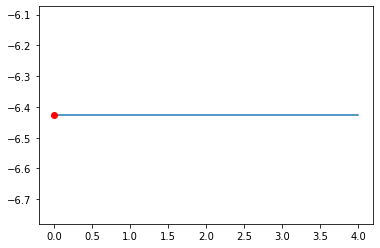

In [40]:
Forecast=np.zeros(5)
Forecast[0]=a[-1]
Forecast[1]=Forecast[0]
Forecast[2]=Forecast[1]
Forecast[3]=Forecast[2]
Forecast[4]=Forecast[3]
plt.plot(Forecast,label='Forecast')
plt.plot(a[-1],'ro',label='a')
plt.show()

### Example 17.3

在Example4.3中，我们用ARIMA(0,1,3)拟合了全球的气温数据，在Example中又用简单指数平滑对其进行了拟合。实际上，这两个模型都可以用State Space Model表示，然后用kalman滤波来进行参数估计，如果把ARIMA(0,1,3)写成向量的形式，则它的State Space Model形式为17.3式，下面我们估计其中的参数$\theta$


In [47]:
temp=pd.read_csv("Global temperature.csv")['value']
SARIMA = sm.tsa.statespace.SARIMAX(temp, trend='c', order=(0,1,3))
res = SARIMA.fit(disp=False,maxiter=100)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                 2016
Model:               SARIMAX(0, 1, 3)   Log Likelihood                1354.137
Date:                Sat, 15 Aug 2020   AIC                          -2698.274
Time:                        19:35:49   BIC                          -2670.232
Sample:                             0   HQIC                         -2687.982
                               - 2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.674      0.500      -0.001       0.002
ma.L1         -0.5044      0.017    -29.204      0.000      -0.538      -0.471
ma.L2         -0.0902      0.020     -4.521      0.000      -0.129      -0.051
ma.L3         -0.1167      0.019     -6.179      0.000      -0.154      -0.080
sigma2         0.0153      0.000     44.061      0.000       0.015       0.016
===================================================================================
Ljung-Box (Q):                      126.23   Jarque-Bera (JB):               499.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

根据结果可知，$\hat{\theta}_1=-0.5044,\hat{\theta}_2=-0.0902,\hat{\theta}_1=-0.1167$，和我们之前所得的结果相吻合。证实了上述结论。